# Machine Learning
## Particle Tracking Heidelberg Dataset - pctdata.csv
---
### Felix Schlembach

Particle Tracking Heidelberg Dataset

Pyton 3.8.8

<img src="https://github.com/FelixSchlembach/ML_PCT/blob/main/pct_data_img1.png?raw=true" style="width: 1000px"/>

## Introduction
---

The data provided is from an experiment where a proton source was being fired at three detector planes. In the following notebook I will show you my approach to reconstruct the path of protons as well as the path they will go

My approach is similar to track seeding with some additional tweaks to the data. Since track seeding is designed to predict the path of protons to save processing power and most importantly time, I chose to take a more data-analytical approach which was sparked solely by quriosity

First preperations actually started disecting the data, playing with it and most importantly: trying to understand what it means. I started by looking at the data in SandDance, which actually saved me lots of time, since I noticed two key things that weren't quite so obvious by just looking at raw data

- Every data point in a cluster has the same i_event, which means I didn't have to run through the data to find cluster

- Adding to that, I didn't have to look far to find the connection where the cluster is on the next plane, since breaking down the data in small blocks revealed that they are labeled by couting down in steps of 100 starting from plane 0

Having said all that: **Let's begin**

## Preparing the base data
---

We will start by first generating a dataframe from the provided .csv file. Then we will calculate some values which will enable us to perform several analyses later

Adding to that, seeing the data and knowing what it actually means will make working with it way easier

### Import dataset from file and save in dataframe

In [443]:
import pandas as pd

df = pd.read_csv("https://github.com/FelixSchlembach/ML_PCT/blob/main/pctdata.csv?raw=true", sep=",")
print(df)

        id_plane   id_x   id_y  i_event  i_time_stamp
0              1  492.0  310.0       32         21600
1              1  493.0  310.0       32         21600
2              1  493.0  311.0       32         21600
3              1  492.0  311.0       32         21600
4              1  493.0  312.0       32         21600
...          ...    ...    ...      ...           ...
220133         0  472.0  271.0   240306   19215829070
220134         0  472.0  272.0   240306   19215829070
220135         0  473.0  272.0   240306   19215829070
220136         0  472.0  273.0   240306   19215829070
220137         0  474.0  271.0   240306   19215829070

[220138 rows x 5 columns]


### Rounded median and mean

In [444]:
df_x_median = int(df["id_x"].median())
df_x_mean = int(df["id_x"].mean())
df_y_median = int(df["id_y"].median())
df_y_mean = int(df["id_y"].mean())
print(" %1s | %6s | %4s |" %("","Median","Mean"))
print("-"*20)
print(" %1s | %6s | %4s |" %("x",df_x_median,df_x_mean))
print(" %1s | %6s | %4s |" %("y",df_y_median,df_y_mean))

   | Median | Mean |
--------------------
 x |    540 |  542 |
 y |    293 |  293 |


### Mean of mean and median

Resulting coordinates ( x , y ) => 

In [445]:
print("(",int((df_x_mean+df_x_median)/2),",",int((df_y_mean+df_y_median)/2),")")

( 541 , 293 )


### A visual representation of all planes stacked

The red dot represents the most likely point where proton source center is located, since it's the middle position of all measurements

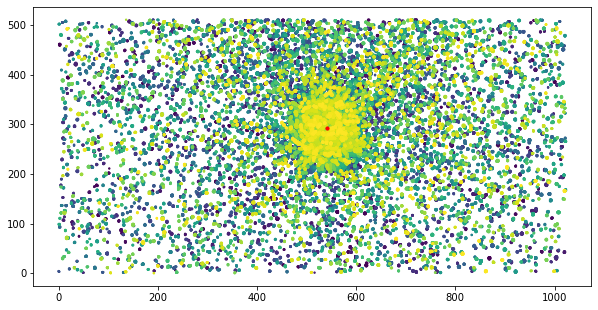

In [446]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.gca().set_aspect("equal")
plt.scatter(df["id_x"], df["id_y"], s=2, c=df["i_event"], cmap="viridis")
plt.scatter([["541"]], [["293"]], s=10, color="red")

Argument could be made, that there is a density inequality on the detector plane. While this might be the case, it's not significant here, since the vast majority of data points are located around the center

This can already be seen in the scatter plot above, since the color is definded by i_event and from that we can derive that there are more i_event's detected in the middle. This is at any given time, since the proton source does not move

*It's important to note, that the color above does **NOT** direktly correlate to density, but to the index of the event. We can just derive it from what we know about the data, that being: The proton source doesn't move and i_event is "constant" at any given time (With some exceptions / gaps, since the beam was fired a total of 16 times with short pauses in beetween)*

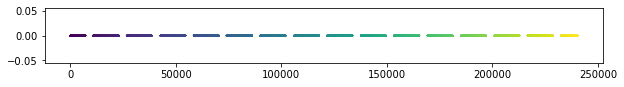

In [447]:
plt.figure(figsize=(10,1))
zero_arr = [0]*len(df["i_event"])
plt.scatter(df["i_event"], zero_arr, s=0.1, c=df["i_event"], cmap="viridis")
plt.show()

### Actual density visualization

The histogram below shows the density of the data points across all planes

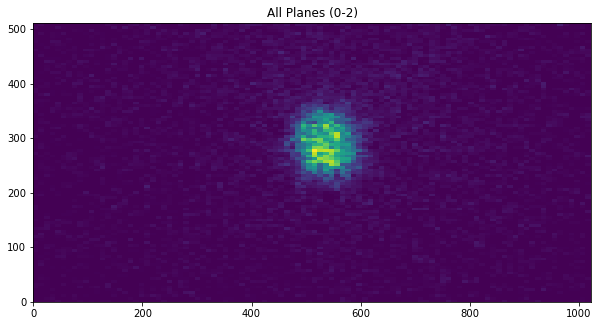

In [448]:
plt.figure(figsize=(10,10))
plt.hist2d(df["id_x"], df["id_y"], bins=(100, 100), cmap="viridis")
plt.gca().set_aspect("equal")
plt.title("All Planes (0-2)")

plt.show()

But we can also split the data into the single planes

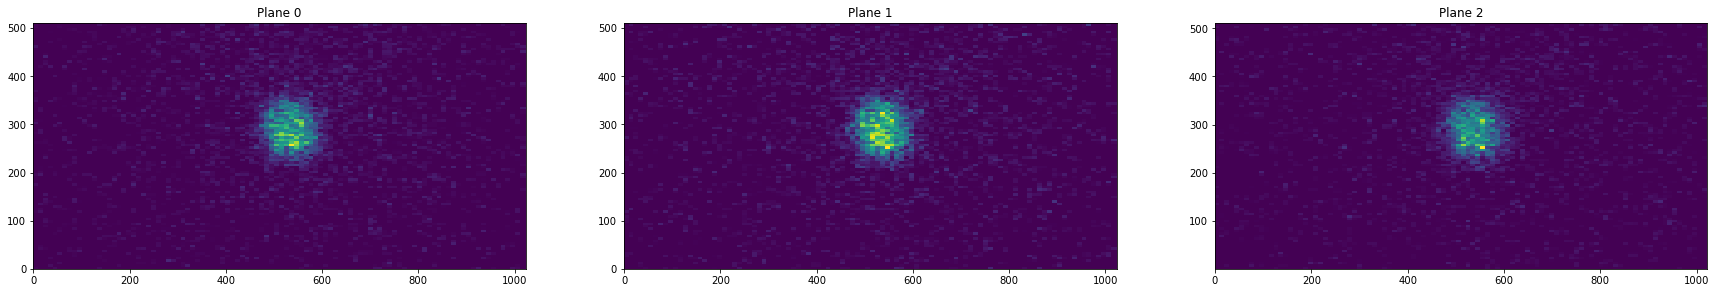

In [449]:
p0_df = df.loc[df["id_plane"] == 0]
p1_df = df.loc[df["id_plane"] == 1]
p2_df = df.loc[df["id_plane"] == 2]

fig, ax = plt.subplots(1,3, figsize = (30, 5))
ax[0].hist2d(p0_df["id_x"], p0_df["id_y"], bins=(100, 100), cmap="viridis")
ax[0].set_title("Plane 0")
ax[0].set_aspect("equal")
ax[1].hist2d(p1_df["id_x"], p1_df["id_y"], bins=(100, 100), cmap="viridis")
ax[1].set_title("Plane 1")
ax[1].set_aspect("equal")
ax[2].hist2d(p2_df["id_x"], p2_df["id_y"], bins=(100, 100), cmap="viridis")
ax[2].set_title("Plane 2")
ax[2].set_aspect("equal")

plt.show()

#### Average distance to the center point

We can also caluclate the average distance to the center to see how much the spread increases on each plane

In [450]:
mid_x = 541
mid_y = 293

avrg_dist = 0
counter = 0
df_arr_x = [p0_df["id_x"], p1_df["id_x"], p2_df["id_x"], df["id_x"]]
df_arr_y = [p0_df["id_y"], p1_df["id_y"], p2_df["id_y"], df["id_y"]]
df_calculated = [[0,0,0],[0,0,0],[0,0,0],[0,0,0]]

for x in df_arr_x:
    df_calculated[counter][2] = len(x)
    for i in x:
        df_calculated[counter][0] += abs(i-mid_x)
    df_calculated[counter][0] = df_calculated[counter][0] / len(x)
    counter += 1
counter = 0

for x in df_arr_y:
    for i in x:
        df_calculated[counter][1] += abs(i-mid_y)
    df_calculated[counter][1] = df_calculated[counter][1] / len(x)
    counter += 1

print("--------------------------------")
print("Total data-points:", df_calculated[3][2]) 
print("All: - x", df_calculated[3][0])
print("All: - y:", df_calculated[3][1])
print("--------------------------------", "\n")

counter = 0
for x in df_calculated:
    print("Plane", counter, "data-points:", df_calculated[counter][2]) 
    print("Plane", counter, ": average distance from center x:", df_calculated[counter][0])
    print("Plane", counter, ": average distance from center y:", df_calculated[counter][1], "\n") 
    counter += 1
    if counter+1 == len(df_calculated) : break

--------------------------------
Total data-points: 220138
All: - x 105.1144509353224
All: - y: 68.91170538480408
-------------------------------- 

Plane 0 data-points: 74595
Plane 0 : average distance from center x: 104.33655070715196
Plane 0 : average distance from center y: 69.83356793350761 

Plane 1 data-points: 75992
Plane 1 : average distance from center x: 105.97486577534477
Plane 1 : average distance from center y: 69.23027423939362 

Plane 2 data-points: 69551
Plane 2 : average distance from center x: 105.00866989691018
Plane 2 : average distance from center y: 67.57491624850829 



The data above shows the average distance from center growing with higher distance. My only explenation for the distance shrinking from plane 1 to plane 2 is that protons are not hitting the plane at the edge anymore and therefore the value get smaller. This is supported by the data-points as well, since the total number of data-points per plane are decreasing from plane 1 to plane 2 significantly

*Later I will show that the distance from the center is increasing generally when looking at more imagenary planes*

## Tracking on a small scale as a proof of concept
---

From what I gathered looking at the data: Every point visible represents a cluster of sensor pixel activations. In additon to that, in the data every pixel activation from the same proton, has the same i_event.
We will calcualte the mean of all the all sensor pixel activations of a particular i_event to get center coordinates where the respective proton passed through the detector plane

The cluster of sensor pixel activations on the next plane have the i_event value -100 meaning: plane 0: **event_id=300**, plane 1: **event_id=200**, plane 2: **event_id=100**

With the cluster mean coordinates we calculate a vector to the next coordinate cluster mean and repeat the calculation.

But first let's visualize the results for one i_event and the vectors drawn in red from plane 0 to plane 1 and plane 1 to plane 2. We will start at i_event 735 from plane 0 and use it as our example from now on

(*Later we could also have an "extra" plane we could use to calucalte from, since we could calculate the intersection point of the vectors and we will have the proton origin point but which we won't use and I will explain why later*)

### The planes

Let's first generate the planes of known data and connect the clusters 735, 635 and 535 to each other

[[644.3846153846154, 672.4615384615385, 697.6153846153846], [414.38461538461536, 435.84615384615387, 460.38461538461536], [0, 1, 2]]


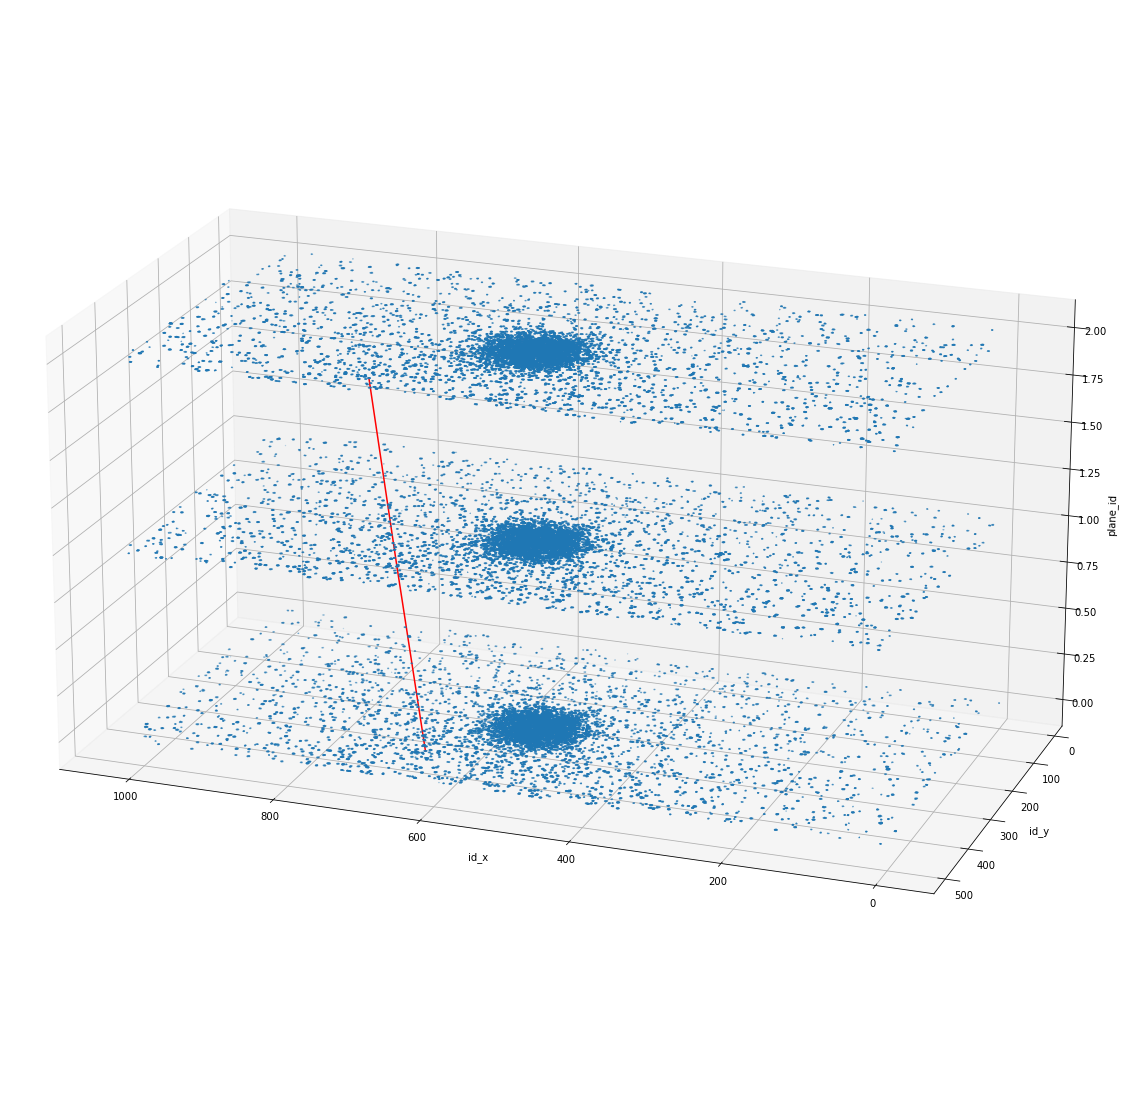

In [451]:
import numpy as np

plane0_cluster = df.loc[df["i_event"] == 735]
plane1_cluster = df.loc[df["i_event"] == 635]
plane2_cluster = df.loc[df["i_event"] == 535]
plane_clusters = [plane0_cluster, plane1_cluster, plane2_cluster]
plane_clusters_meancords = [[0,0,0],[0,0,0],[0,1,2]]

counter = 0
for i in plane_clusters:
    plane_clusters_meancords[0][counter] = sum(i["id_x"])/len(i["id_x"])
    counter += 1
counter = 0
for i in plane_clusters:
    plane_clusters_meancords[1][counter] = sum(i["id_y"])/len(i["id_y"])
    counter += 1

print(plane_clusters_meancords)


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (10, 5, 5))
ax.view_init(elev=20, azim=110)

ax.plot3D(plane_clusters_meancords[0], plane_clusters_meancords[1], plane_clusters_meancords[2], "red")
ax.scatter(df["id_x"], df["id_y"], df["id_plane"], s=0.1)

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')

plt.show()

#### Now lets add the intersection point on plane 3 and 4

To do this, we will just calculate the vector and add it to the cluster coordinates of plane 2 once and twice

The yellow dots will represent the coordinate hit on the respective plane, to help visualize where the proton passed through the imaginary plane

[26.61538461538464, 23.0, 1.0]
[[644.3846153846154, 672.4615384615385, 697.6153846153846, 724.2307692307693, 750.8461538461539], [414.38461538461536, 435.84615384615387, 460.38461538461536, 483.38461538461536, 506.38461538461536], [0, 1, 2, 3.0, 4.0]]


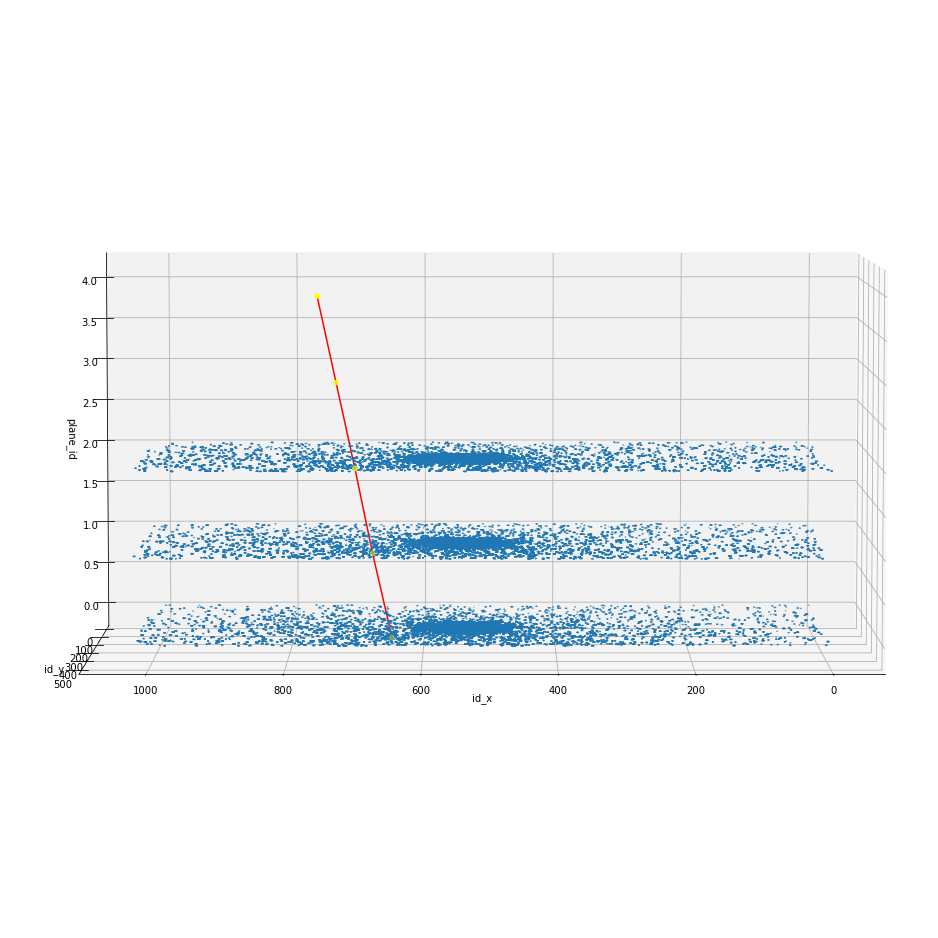

In [452]:
import copy

vector = [0,0,0]
for i in range(len(plane_clusters_meancords)):
    for j in range(len(plane_clusters_meancords[i])-1):
        vector[i] += abs(plane_clusters_meancords[i][j+1]-plane_clusters_meancords[i][j])
    vector[i] /= len(plane_clusters_meancords[i])-1
print(vector)

new_cords = copy.deepcopy(plane_clusters_meancords)
i = 0
while i < 2:
    new_cords[0].append(new_cords[0][len(new_cords[0])-1]+vector[0])
    new_cords[1].append(new_cords[1][len(new_cords[1])-1]+vector[1])
    new_cords[2].append(new_cords[2][len(new_cords[2])-1]+vector[2])
    i += 1
print(new_cords)

fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (10, 5, 5))
ax.view_init(elev=5, azim=90)

ax.plot3D(new_cords[0], new_cords[1], new_cords[2], "red")
ax.scatter(new_cords[0], new_cords[1], new_cords[2], s=20, c="yellow")
ax.scatter(df["id_x"], df["id_y"], df["id_plane"], s=0.1)

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')

plt.show()

### Lets track the particle backwards

This is the same concept as before, but now we use substraction instead of addition

The green line represents the "center" point (541, 293)

The purple line represents the line from the center point at z: -4 to the top most point

-4 is used to visualize the problems you get by using just a point in space instead of an area

[[537.9230769230768, 564.5384615384614, 591.1538461538461, 617.7692307692307, 644.3846153846154, 672.4615384615385, 697.6153846153846, 724.2307692307693, 750.8461538461539], [322.38461538461536, 345.38461538461536, 368.38461538461536, 391.38461538461536, 414.38461538461536, 435.84615384615387, 460.38461538461536, 483.38461538461536, 506.38461538461536], [-4.0, -3.0, -2.0, -1.0, 0, 1, 2, 3.0, 4.0]]


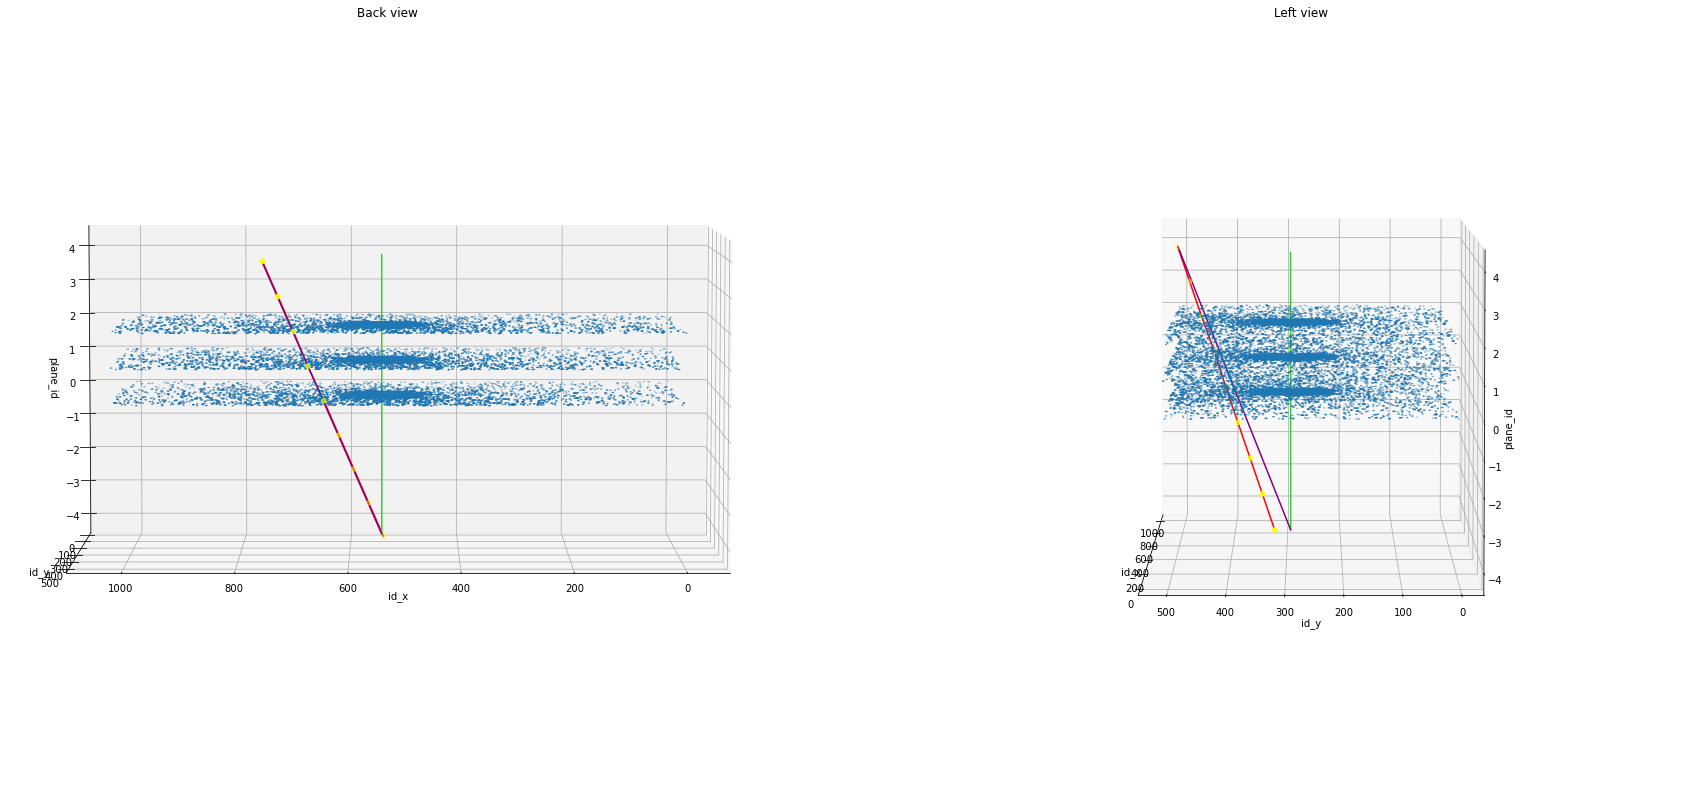

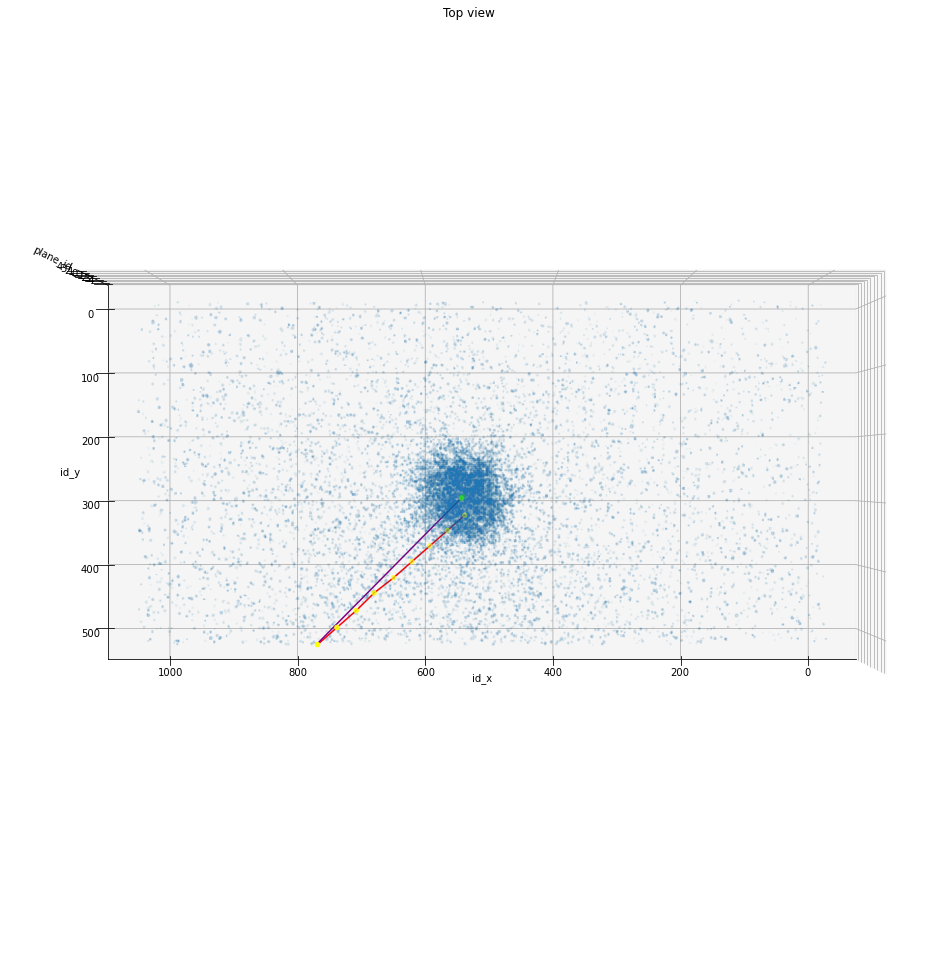

In [453]:
i=0
while i < 4:
    new_cords[0].insert(0, new_cords[0][0]-vector[0])
    new_cords[1].insert(0, new_cords[1][0]-vector[1])
    new_cords[2].insert(0, new_cords[2][0]-vector[2])
    i+=1
    
print(new_cords)

fig = plt.figure(figsize=(30, 60))


ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_box_aspect(aspect = (10, 5, 5))
ax.view_init(elev=5, azim=90)
ax.set_title("Back view")

ax.plot3D(new_cords[0], new_cords[1], new_cords[2], "red")
ax.plot3D([541, 541], [293, 293] , [-4,4], "limegreen")
ax.plot3D([541, 752], [293, 506] , [-4,4], "purple")
#( 541 , 293 )
ax.scatter(new_cords[0], new_cords[1], new_cords[2], s=20, c="yellow")
ax.scatter(df["id_x"], df["id_y"], df["id_plane"], s=0.01)

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')



ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_box_aspect(aspect = (10, 5, 5))
ax.view_init(elev=5, azim=180)
ax.set_title("Left view")

ax.plot3D(new_cords[0], new_cords[1], new_cords[2], "red")
ax.plot3D([541, 541], [293, 293] , [-4,4], "limegreen")
ax.plot3D([541, 752], [293, 506] , [-4,4], "purple")
#( 541 , 293 )
ax.scatter(new_cords[0], new_cords[1], new_cords[2], s=20, c="yellow")
ax.scatter(df["id_x"], df["id_y"], df["id_plane"], s=0.01)

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')

plt.show()

fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (10, 5, 5))
ax.view_init(elev=90, azim=90)
ax.set_title("Top view")

ax.plot3D(new_cords[0], new_cords[1], new_cords[2], "red")
ax.scatter([541, 541], [293, 293] , [-4,4], s=20, c="limegreen")
ax.plot3D([541, 752], [293, 506] , [-4,4], "purple")
#( 541 , 293 )
ax.scatter(new_cords[0], new_cords[1], new_cords[2], s=20, c="yellow")
ax.scatter(df["id_x"], df["id_y"], df["id_plane"], s=0.001)

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')

plt.show()

As you can see, from the front / back the lines appear to intersect, but the side view shows that the calculated vector "misses" the center point

This might suggest that the calculations were incorrect, but since in reality the protons can't be shot from an infinitesimal small point, so we have to imagine the protons comming out of an area rather than a point

There is also the possibility, that some of the protons bounce of the inside of the proton emitter and are therefore able to travel at an angle which would't normally be possible

Since we can't really pinpoint the source to one infinitesimal small point, we could just try to determine the source **area**, which wouldn't *really* help us here, so we'll just skip over that

## Generating an entire plane of "imaginary" data-points
---

This will be the same concept as used above to track one particle, with some important to note exceptions: 

- Particles may only have one or two clusters
- Particles with two clusters will only have the vector between them to use
- Particles with one cluster do not have a vector, so we create a vector from the "center" point to be able to track them too. Yes, we could use the aforementioned "center area" and get the nearest point on the area based on where other clusters in the datataset originated from. However, this would require an hefty amount of computing power and it would be beyond the scope of what I am trying to show here. Adding to that, particles that went this far to the senor edge are small in number will not have a major impact on the overall results

Generating a vector not from the center area but a point does carry some side effects with it. The vectors calucalted for these points will have a shallower angle than the correct angle would be. This is noticable when we dislpay points from real-data-vectors and the "subsitute vectors"

### Generating plane 3 and 4

#### Calculating the mean coordinate data

The code below was used to generate the event_meancord_df.csv file. The file holds the data of each event-clusters mean coordinates and the corresponding vector.

Since we first have to calcualte the mean coordinates and then the vectors for each, it took me about 3 minutes to calculate / generate the data and write it to the file. That's why I provided the calculated data and we just import it. But the code works and if you want, you can run it yourself

As mentioned above, it's basically the same process as calculating the mean coordinates of one event cluster group e.g.: (735, 635, 535) but including the exception for reaching either the outer most plane or there just being one plane in the first place

We then write the data to the file. Afterwards we can just import the data as a new dataframe. This reduces the number of rows from 220.139 to 22.789 so that's an average of about ~10 data-points per cluster

In [454]:
"""
event_meancord_vector_df = [] # [ {"i_event": 1234, "id_x": 123, "id_y": 456, "id_z": 789, "v_x": 123, "v_y": 456, "v_z": 789, }, {...}, ... ]

counter = 0
for x in df["i_event"].unique():
    event_meancord_vector_df.append(dict())
    event_meancord_vector_df[counter]["i_event"] = x

    eventcluster = df.loc[df["i_event"] == x]

    event_meancord_vector_df[counter]["id_x"] = sum(eventcluster["id_x"])/len(eventcluster["id_x"])
    event_meancord_vector_df[counter]["id_y"] = sum(eventcluster["id_y"])/len(eventcluster["id_y"])
    event_meancord_vector_df[counter]["id_z"] = eventcluster["id_plane"].max()
    counter += 1

counter = 0
p100 = 0
for x in event_meancord_vector_df:
    for j in event_meancord_vector_df:
        if j["i_event"] == x["i_event"]+100:
            p100 = j
            break
    if p100:
        event_meancord_vector_df[counter]["v_x"] = event_meancord_vector_df[counter]["id_x"] - p100["id_x"]
        event_meancord_vector_df[counter]["v_y"] = event_meancord_vector_df[counter]["id_y"] - p100["id_y"]
        event_meancord_vector_df[counter]["v_z"] = 1
    else:
        event_meancord_vector_df[counter]["v_x"] = (event_meancord_vector_df[counter]["id_x"]-541)/4
        event_meancord_vector_df[counter]["v_y"] = (event_meancord_vector_df[counter]["id_y"]-293)/4
        event_meancord_vector_df[counter]["v_z"] = 1
    counter += 1
    p100 = 0
import csv

columns = ("i_event", "id_x", "id_y", "id_z", "v_x", "v_y", "v_z")
keys = event_meancord_vector_df[0].keys()

with open('event_meancord_vector_df.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(event_meancord_vector_df)
"""
new_df = pd.read_csv("https://github.com/FelixSchlembach/ML_PCT/blob/main/event_meancord_vector_df.csv?raw=true", sep=",")
print(new_df)

       i_event        id_x        id_y  id_z        v_x        v_y  v_z
0           32  494.000000  312.000000     1 -11.750000   4.750000    1
1           33  493.750000  311.833333     1   1.386364  -0.621212    1
2           47  558.909091  423.363636     2   4.477273  32.590909    1
3           48  559.000000  423.500000     2  -5.800000  13.000000    1
4           54  535.333333  292.111111     2  -1.416667  -0.222222    1
...        ...         ...         ...   ...        ...        ...  ...
22784   240257  643.500000  381.500000     0  25.625000  22.125000    1
22785   240258  643.500000  381.500000     0  25.625000  22.125000    1
22786   240276  499.000000  483.285714     0 -10.500000  47.571429    1
22787   240277  499.000000  483.333333     0 -10.500000  47.583333    1
22788   240306  472.181818  271.181818     0 -17.204545  -5.454545    1

[22789 rows x 7 columns]


#### Calculating the points of plane 3 and 4

The claculated points / planes do not get saved, they are just displayed. They are generated by taking all points from the last sensor plane and adding the corresponding vector to it. For the 4th plane we just add the vector twice

The red line ist just a reference to the the example point from above, where we used a the related group cluster 735, 635 and 535. Basically we now generated 435 and 335

[[537.9230769230768, 564.5384615384614, 591.1538461538461, 617.7692307692307, 644.3846153846154, 672.4615384615385, 697.6153846153846, 724.2307692307693, 750.8461538461539], [322.38461538461536, 345.38461538461536, 368.38461538461536, 391.38461538461536, 414.38461538461536, 435.84615384615387, 460.38461538461536, 483.38461538461536, 506.38461538461536], [-4.0, -3.0, -2.0, -1.0, 0, 1, 2, 3.0, 4.0]]
[644.3846153846154, 672.4615384615385, 697.6153846153846, 697.6153846153846, 722.7692307692308, 747.923076923077]


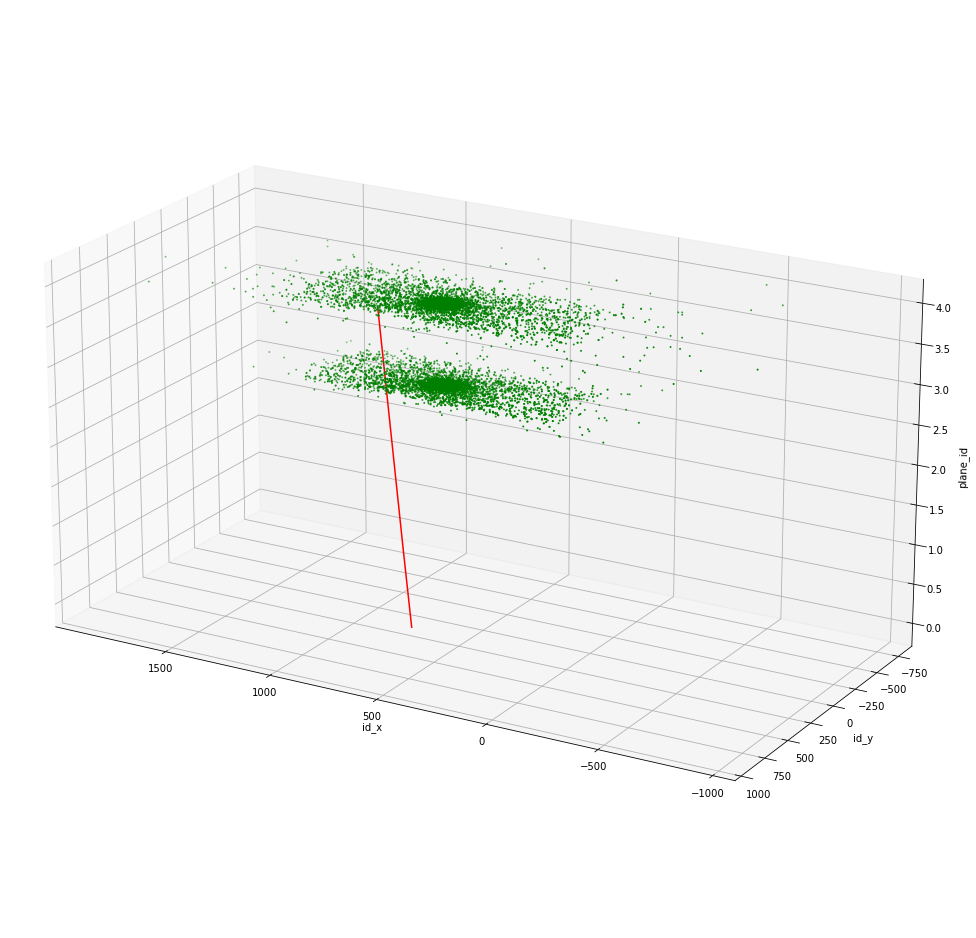

In [455]:
fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (10, 5, 5))
ax.view_init(elev=20, azim=120)

#ax.scatter(new_df["id_x"], new_df["id_y"], new_df["id_z"], s=1)

plane_2 = new_df.loc[new_df["id_z"] == 2]

plane0_cluster = new_df.loc[new_df["i_event"] == 735]
plane1_cluster = new_df.loc[new_df["i_event"] == 635]
plane2_cluster = new_df.loc[new_df["i_event"] == 535]
plane3_cluster = new_df.loc[new_df["i_event"] == 535]

x,y,z = [],[],[]
for i in range(0,4):
    x.append(eval("plane"+str(i)+"_cluster")["id_x"].values[0])
    y.append(eval("plane"+str(i)+"_cluster")["id_y"].values[0])
    z.append(eval("plane"+str(i)+"_cluster")["id_z"].values[0])

x.append(plane3_cluster["id_x"].values[0]+plane3_cluster["v_x"].values[0])
y.append(plane3_cluster["id_y"].values[0]+plane3_cluster["v_y"].values[0])
z.append(plane3_cluster["id_z"].values[0]+plane3_cluster["v_z"].values[0])
x.append(plane3_cluster["id_x"].values[0]+plane3_cluster["v_x"].values[0]*2)
y.append(plane3_cluster["id_y"].values[0]+plane3_cluster["v_y"].values[0]*2)
z.append(plane3_cluster["id_z"].values[0]+plane3_cluster["v_z"].values[0]*2)


print(new_cords)
print(x)
ax.scatter(plane_2["id_x"]+plane_2["v_x"], plane_2["id_y"]+plane_2["v_y"], plane_2["id_z"]+plane_2["v_z"], s=1, c="green")
ax.scatter(plane_2["id_x"]+plane_2["v_x"]+plane_2["v_x"], plane_2["id_y"]+plane_2["v_y"]+plane_2["v_y"], plane_2["id_z"]+plane_2["v_z"]+plane_2["v_z"], s=1, c="green")
ax.plot3D(x,y,z, "red")

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')

plt.show()

Now let's add back the detector planes

[[537.9230769230768, 564.5384615384614, 591.1538461538461, 617.7692307692307, 644.3846153846154, 672.4615384615385, 697.6153846153846, 724.2307692307693, 750.8461538461539], [322.38461538461536, 345.38461538461536, 368.38461538461536, 391.38461538461536, 414.38461538461536, 435.84615384615387, 460.38461538461536, 483.38461538461536, 506.38461538461536], [-4.0, -3.0, -2.0, -1.0, 0, 1, 2, 3.0, 4.0]]
[644.3846153846154, 672.4615384615385, 697.6153846153846, 697.6153846153846, 722.7692307692308, 747.923076923077]


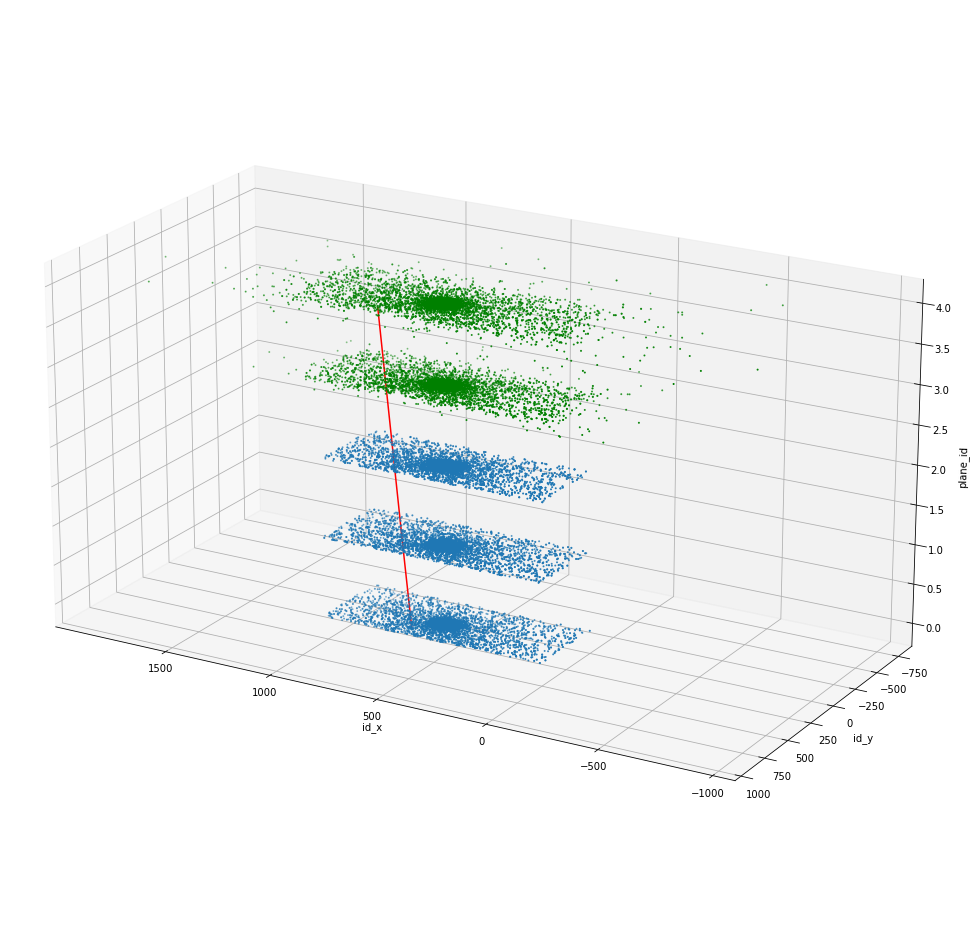

In [456]:
fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (10, 5, 5))
ax.view_init(elev=20, azim=120)

ax.scatter(new_df["id_x"], new_df["id_y"], new_df["id_z"], s=1)

plane_1 = new_df.loc[new_df["id_z"] == 1]
plane_2 = new_df.loc[new_df["id_z"] == 2]

plane0_cluster = new_df.loc[new_df["i_event"] == 735]
plane1_cluster = new_df.loc[new_df["i_event"] == 635]
plane2_cluster = new_df.loc[new_df["i_event"] == 535]
plane3_cluster = new_df.loc[new_df["i_event"] == 535]

x,y,z = [],[],[]
for i in range(0,4):
    x.append(eval("plane"+str(i)+"_cluster")["id_x"].values[0])
    y.append(eval("plane"+str(i)+"_cluster")["id_y"].values[0])
    z.append(eval("plane"+str(i)+"_cluster")["id_z"].values[0])

x.append(plane3_cluster["id_x"].values[0]+plane3_cluster["v_x"].values[0])
y.append(plane3_cluster["id_y"].values[0]+plane3_cluster["v_y"].values[0])
z.append(plane3_cluster["id_z"].values[0]+plane3_cluster["v_z"].values[0])
x.append(plane3_cluster["id_x"].values[0]+plane3_cluster["v_x"].values[0]*2)
y.append(plane3_cluster["id_y"].values[0]+plane3_cluster["v_y"].values[0]*2)
z.append(plane3_cluster["id_z"].values[0]+plane3_cluster["v_z"].values[0]*2)


print(new_cords)
print(x)
ax.scatter(plane_2["id_x"]+plane_2["v_x"], plane_2["id_y"]+plane_2["v_y"], plane_2["id_z"]+plane_2["v_z"], s=1, c="green")
ax.scatter(plane_2["id_x"]+plane_2["v_x"]+plane_2["v_x"], plane_2["id_y"]+plane_2["v_y"]+plane_2["v_y"], plane_2["id_z"]+plane_2["v_z"]+plane_2["v_z"], s=1, c="green")
ax.plot3D(x,y,z, "red")

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')

plt.show()

### Data-points that went beyond the bounds of the detector planes

To calculate the lost data, we will check which points from plane 1 plus their vector would not hit plane 2. These points will be displayed in purple

- For x we check is the proton position + vector is greater 1000 or smaller 0
- For y we check if the proton position + vector is greater 500 or smaller 0

For visual display we will only use protons originating from plane 1 since plane 0 protons do not have the real vector and will not be displayed properly. We could use the algorithms to get the real vector, but that would defeat the purpose of tracking seeding, since it would increase not decrease the calulations needed for a comparatively small number of data points retrieved

Now let's also track the points which went beyond the bounds

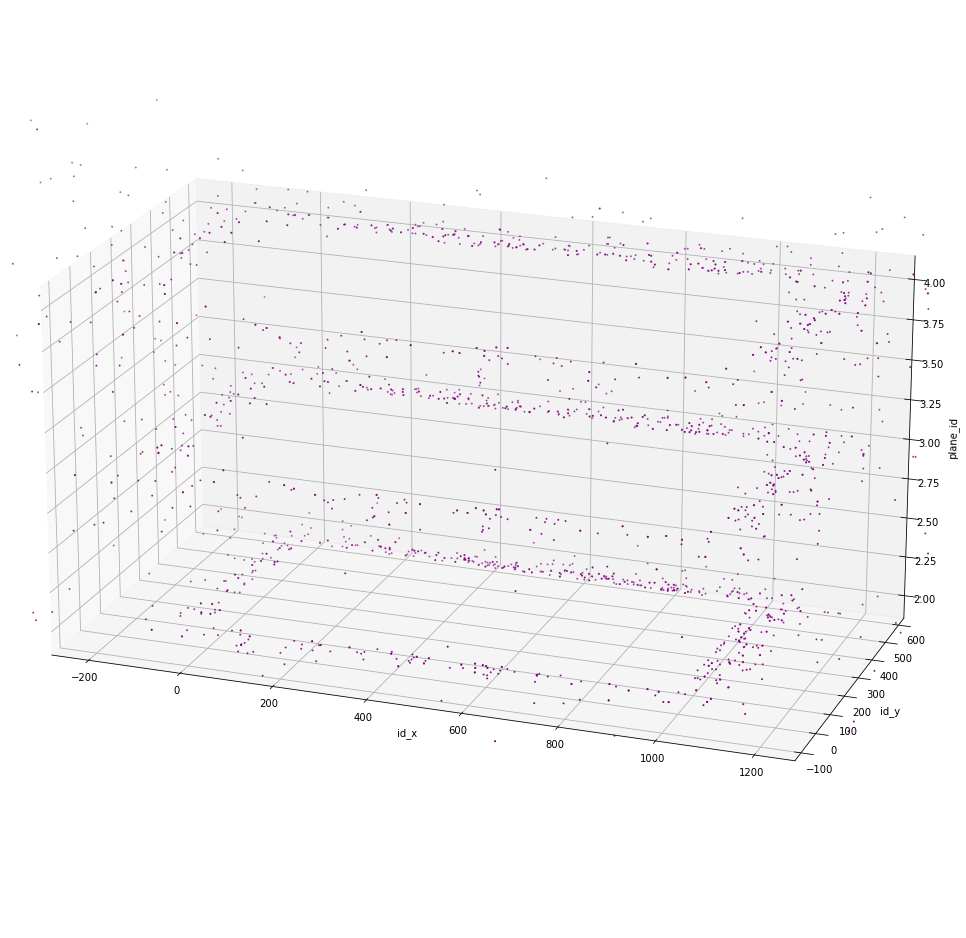

In [457]:
plane_0_out = new_df.loc[(new_df["id_z"] == 0) & ((new_df["id_x"]+new_df["v_x"] > 1000) | (new_df["id_x"]+new_df["v_x"] < 0) | (new_df["id_y"]+new_df["v_y"] > 500) | (new_df["id_y"]+new_df["v_y"] < 0))]
plane_1_out = new_df.loc[(new_df["id_z"] == 1) & ((new_df["id_x"]+new_df["v_x"] > 1000) | (new_df["id_x"]+new_df["v_x"] < 0) | (new_df["id_y"]+new_df["v_y"] > 500) | (new_df["id_y"]+new_df["v_y"] < 0))]
plane_2_out = new_df.loc[(new_df["id_z"] == 2) & ((new_df["id_x"]+new_df["v_x"] > 1000) | (new_df["id_x"]+new_df["v_x"] < 0) | (new_df["id_y"]+new_df["v_y"] > 500) | (new_df["id_y"]+new_df["v_y"] < 0))]
plane_3_out = new_df.loc[(new_df["id_z"] == 3) & ((new_df["id_x"]+new_df["v_x"] > 1000) | (new_df["id_x"]+new_df["v_x"] < 0) | (new_df["id_y"]+new_df["v_y"] > 500) | (new_df["id_y"]+new_df["v_y"] < 0))]

x,y,z = [],[],[]
"""
for i in range(1,5):
    x.append((plane_0_out["id_x"]+plane_0_out["v_x"]*i).tolist())
    y.append((plane_0_out["id_y"]+plane_0_out["v_y"]*i).tolist())
    z.append((plane_0_out["id_z"]+plane_0_out["v_z"]*i).tolist())
    """
for i in range(1,4):
    x.append((plane_1_out["id_x"]+plane_1_out["v_x"]*i).tolist())
    y.append((plane_1_out["id_y"]+plane_1_out["v_y"]*i).tolist())
    z.append((plane_1_out["id_z"]+plane_1_out["v_z"]*i).tolist())
"""
for i in range(1,3):
    x.append((plane_2_out["id_x"]+plane_2_out["v_x"]*i).tolist())
    y.append((plane_2_out["id_y"]+plane_2_out["v_y"]*i).tolist())
    z.append((plane_2_out["id_z"]+plane_2_out["v_z"]*i).tolist())
for i in range(1,2):
    x.append((plane_3_out["id_x"]+plane_3_out["v_x"]*i).tolist())
    y.append((plane_3_out["id_y"]+plane_3_out["v_y"]*i).tolist())
    z.append((plane_3_out["id_z"]+plane_3_out["v_z"]*i).tolist())
"""
fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (10, 5, 5))
ax.view_init(elev=20, azim=-70)

for i in range(0,3):
    ax.scatter(x[i],y[i],z[i], s=1, color="purple")

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')
ax.set_xlim(-250, 1250)
ax.set_ylim(-125, 625)

plt.show()

### Revisiting the spread of protons

Now that we have all the data on planes 3 and 4, we can show the average distance from the center increasing and the density of data-points decreasing

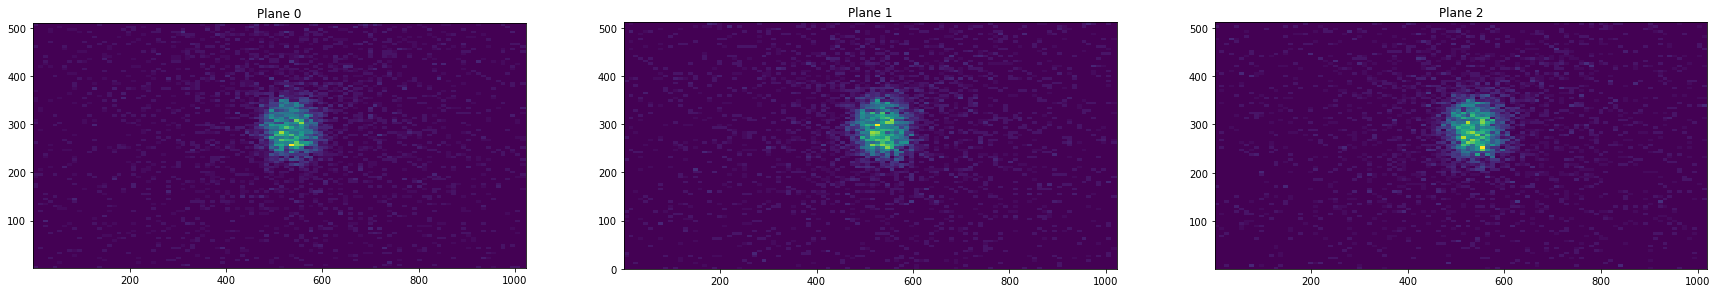

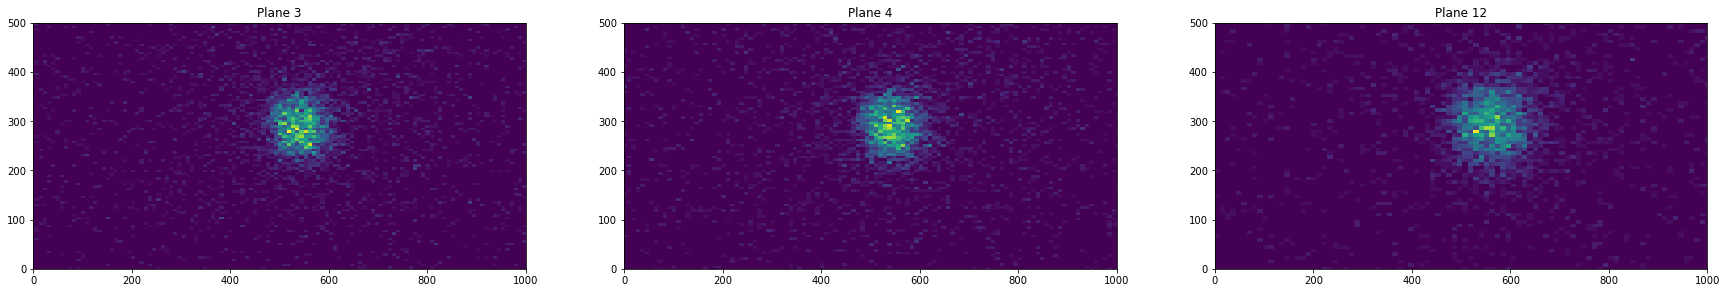

In [458]:
p0_df = new_df.loc[new_df["id_z"] == 0]
p1_df = new_df.loc[new_df["id_z"] == 1]
p2_df = new_df.loc[new_df["id_z"] == 2]

fig, ax = plt.subplots(1,3, figsize = (30, 5))
ax[0].hist2d(p0_df["id_x"], p0_df["id_y"], bins=(100, 100), cmap="viridis")
ax[0].set_title("Plane 0")
ax[0].set_aspect("equal")
ax[1].hist2d(p1_df["id_x"], p1_df["id_y"], bins=(100, 100), cmap="viridis")
ax[1].set_title("Plane 1")
ax[1].set_aspect("equal")
ax[2].hist2d(p2_df["id_x"], p2_df["id_y"], bins=(100, 100), cmap="viridis")
ax[2].set_title("Plane 2")
ax[2].set_aspect("equal")

plt.show()

fig, ax = plt.subplots(1,3, figsize = (30, 5))
ax[0].hist2d(p2_df["id_x"]+p2_df["v_x"]*1, p2_df["id_y"]+p2_df["v_y"]*1, bins=(200, 200), cmap="viridis")
ax[0].set_title("Plane 3")
ax[0].set_aspect("equal")
ax[0].set_xlim(0, 1000)
ax[0].set_ylim(0, 500)
ax[1].hist2d(p2_df["id_x"]+p2_df["v_x"]*2, p2_df["id_y"]+p2_df["v_y"]*2, bins=(300, 300), cmap="viridis")
ax[1].set_title("Plane 4")
ax[1].set_aspect("equal")
ax[1].set_xlim(0, 1000)
ax[1].set_ylim(0, 500)
ax[2].hist2d(p2_df["id_x"]+p2_df["v_x"]*10, p2_df["id_y"]+p2_df["v_y"]*10, bins=(1000, 1000), cmap="viridis")
ax[2].set_title("Plane 12")
ax[2].set_aspect("equal")
ax[2].set_xlim(0, 1000)
ax[2].set_ylim(0, 500)

plt.show()

As you can see by the data visualized above, the spread increased with every plane

I inlcuded what the plane 12 spread would look like, because there you can really see the density decrease around / in the center


## Conclusion
---

- We can use the groups of clusters to caluclate mean coordinates and create vectors connecting them

- And we have seen, that we can predict the trajectory of the protons and that this can also be used to track the particles backwards

- We can also calculate the position of particles that went beyond the boundaries of the detector

### Combining all findings

If we now take everything we calculated before and put it in one single plot it's quite something to look at

But first a little reminder of what data we started with

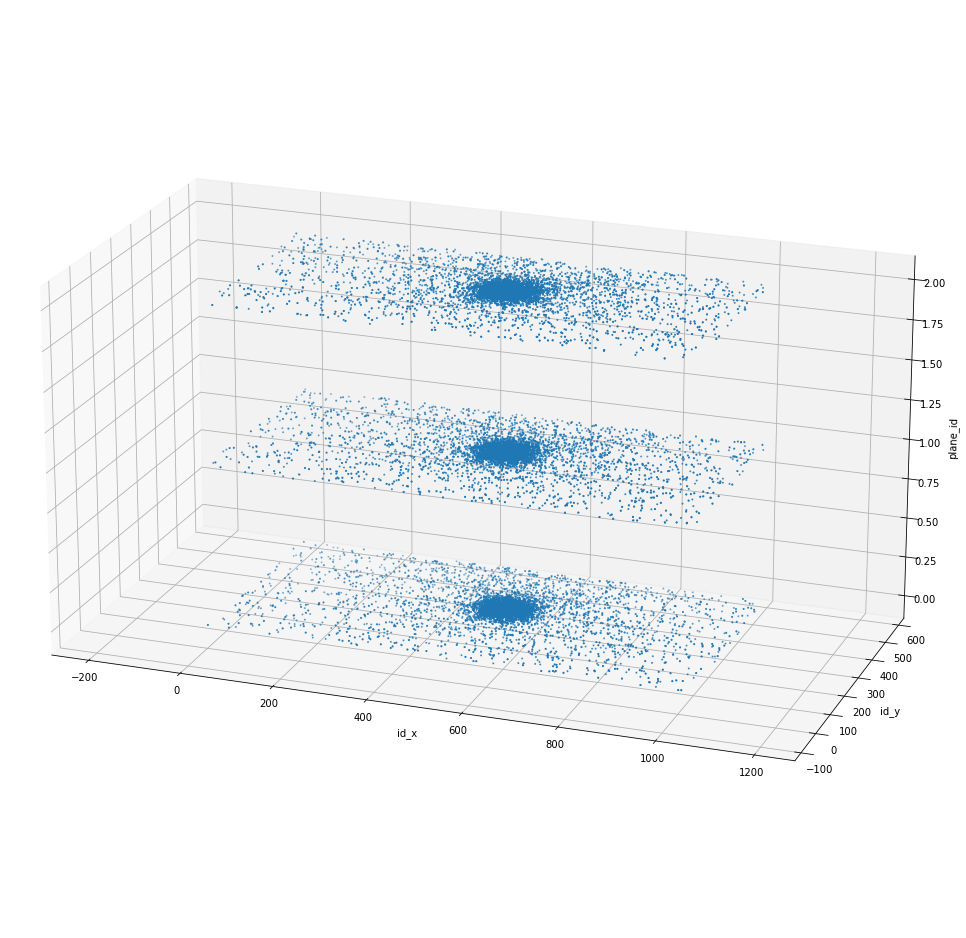

In [459]:
fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (10, 5, 5))
ax.view_init(elev=20, azim=-70)

ax.scatter(new_df["id_x"], new_df["id_y"], new_df["id_z"], s=1)
ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')
ax.set_xlim(-250, 1250)
ax.set_ylim(-125, 625)
plt.show()

### The final result:

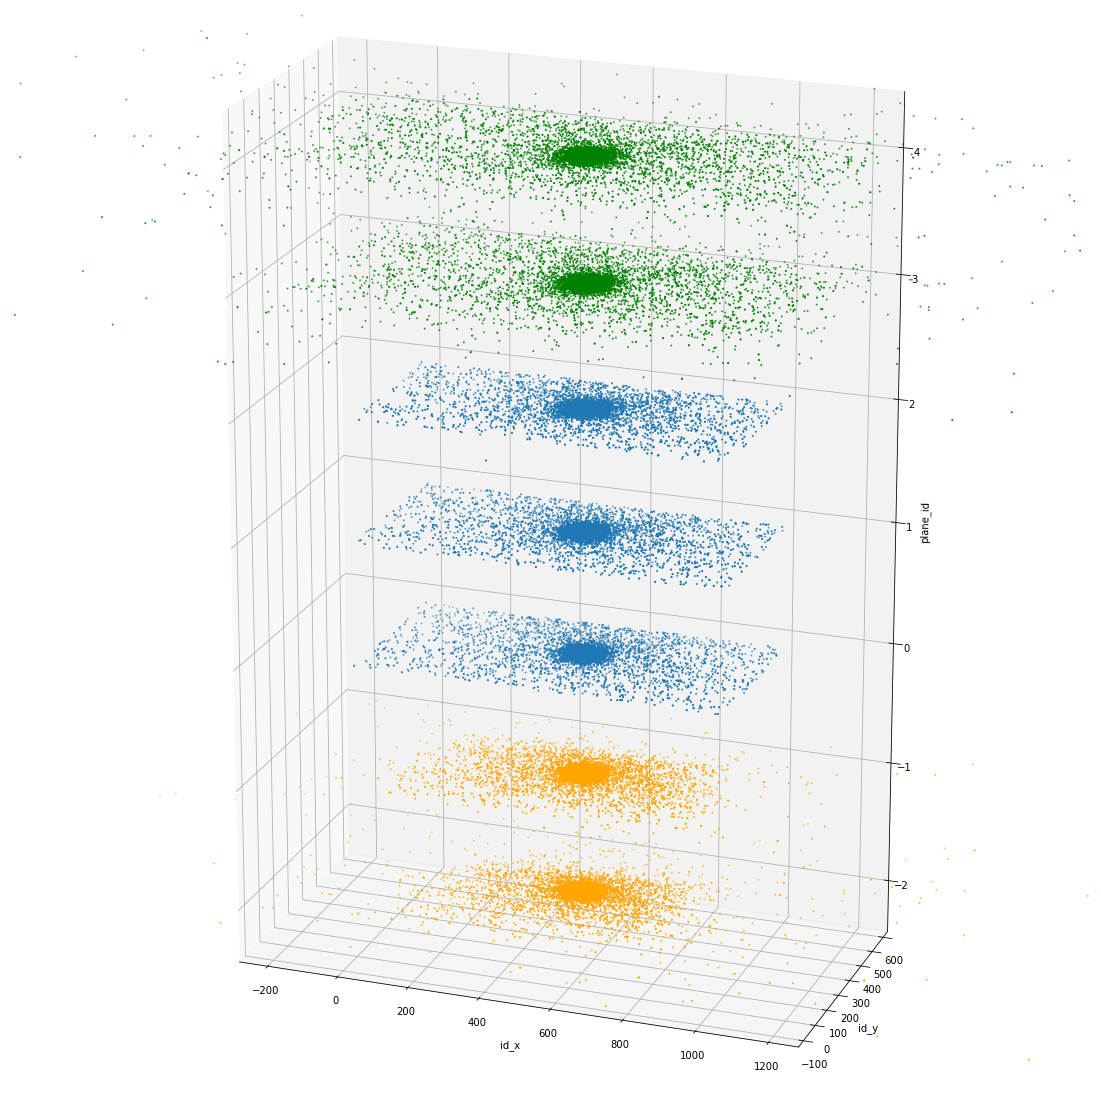

In [460]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (10, 5, 15))
ax.view_init(elev=20, azim=-70)

ax.scatter(new_df["id_x"], new_df["id_y"], new_df["id_z"], s=1)

#for i in range(0,3):
#    ax.scatter(x[i],y[i],z[i], s=1, color="purple")

ax.scatter(plane_1["id_x"]+plane_1["v_x"]*2, plane_1["id_y"]+plane_1["v_y"]*3, plane_1["id_z"]+plane_1["v_z"]*2, s=1, c="green")
ax.scatter(plane_1["id_x"]+plane_1["v_x"]*3, plane_1["id_y"]+plane_1["v_y"]*3, plane_1["id_z"]+plane_1["v_z"]*3, s=1, c="green")

ax.scatter(plane_1["id_x"]-plane_1["v_x"]*2, plane_1["id_y"]-plane_1["v_y"]*2, plane_1["id_z"]-plane_1["v_z"]*2, s=1, c="orange")
ax.scatter(plane_1["id_x"]-plane_1["v_x"]*3, plane_1["id_y"]-plane_1["v_y"]*3, plane_1["id_z"]-plane_1["v_z"]*3, s=1, c="orange")

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')
ax.set_xlim(-250, 1250)
ax.set_ylim(-125, 625)

plt.show()

Now let's also add the points which went went beyond the detector plane

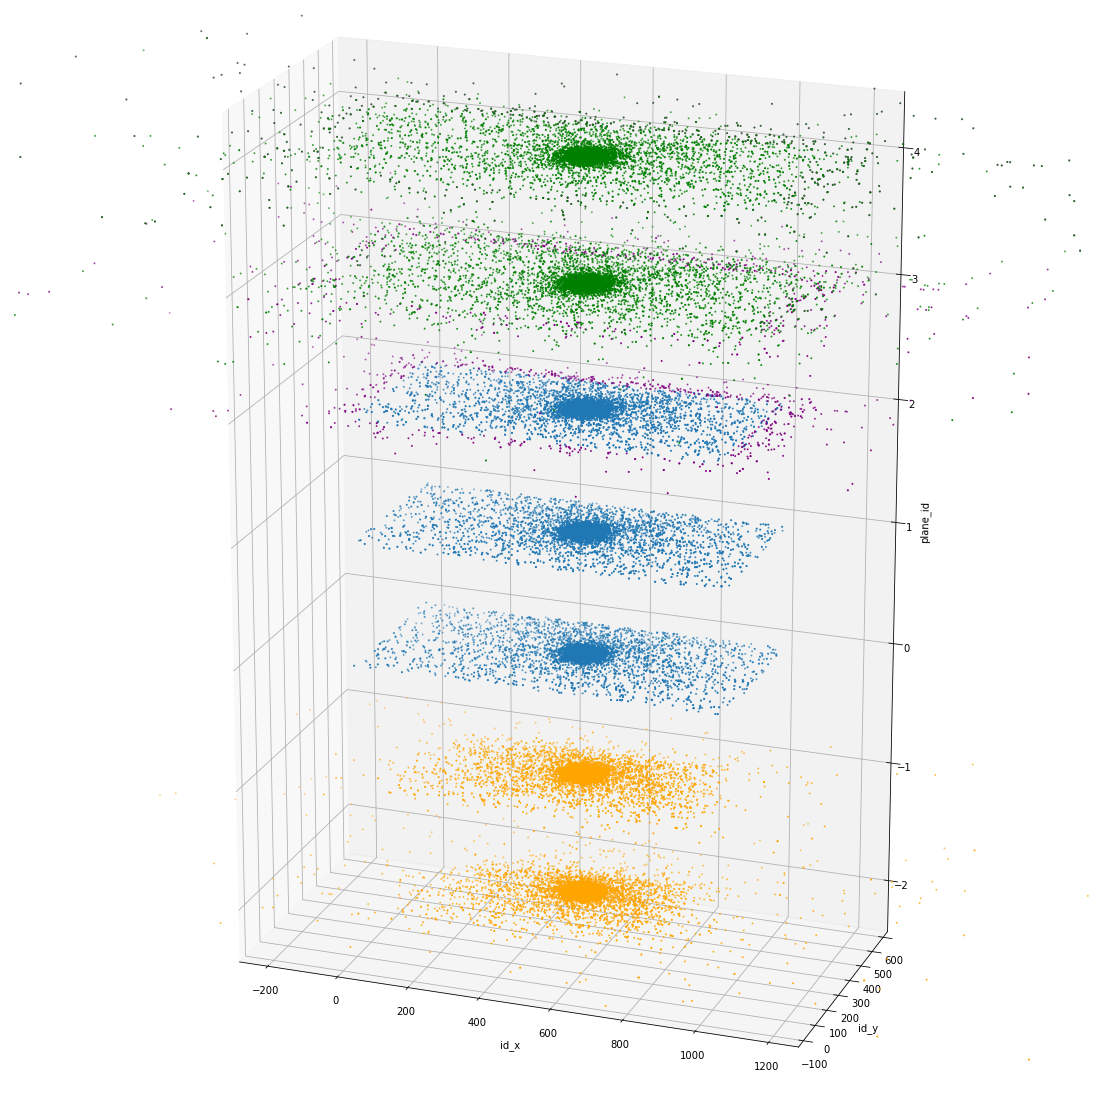

In [461]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (10, 5, 15))
ax.view_init(elev=20, azim=-70)

ax.scatter(new_df["id_x"], new_df["id_y"], new_df["id_z"], s=1)

for i in range(0,3):
    ax.scatter(x[i],y[i],z[i], s=1, color="purple")

ax.scatter(plane_1["id_x"]+plane_1["v_x"]*2, plane_1["id_y"]+plane_1["v_y"]*3, plane_1["id_z"]+plane_1["v_z"]*2, s=1, c="green")
ax.scatter(plane_1["id_x"]+plane_1["v_x"]*3, plane_1["id_y"]+plane_1["v_y"]*3, plane_1["id_z"]+plane_1["v_z"]*3, s=1, c="green")

ax.scatter(plane_1["id_x"]-plane_1["v_x"]*2, plane_1["id_y"]-plane_1["v_y"]*2, plane_1["id_z"]-plane_1["v_z"]*2, s=1, c="orange")
ax.scatter(plane_1["id_x"]-plane_1["v_x"]*3, plane_1["id_y"]-plane_1["v_y"]*3, plane_1["id_z"]-plane_1["v_z"]*3, s=1, c="orange")

ax.set_xlabel('id_x')
ax.set_ylabel('id_y')
ax.set_zlabel('plane_id')
ax.set_xlim(-250, 1250)
ax.set_ylim(-125, 625)

plt.show()

---
---
<span style="font-size: 200%; text-shadow: 2px 2px 10px blue"><span style="text-shadow: 2px 2px 10px red">EOF:</span> Thanks for reading and / or your attention!</span>

---
---